get resnet50 V2 freeze all convolution layer 

# Read in data from annotation and png 

In [11]:
from google.colab import drive
drive.mount('/content/drive')
!unzip  "/content/drive/My Drive/Colab Notebooks/mhist_dataset.zip" 

Mounted at /content/drive
Archive:  /content/drive/My Drive/Colab Notebooks/mhist_dataset.zip
   creating: mhist_dataset/
  inflating: mhist_dataset/annotations.csv  
   creating: mhist_dataset/images/
  inflating: mhist_dataset/images/MHIST_aaa.png  
  inflating: mhist_dataset/images/MHIST_aab.png  
  inflating: mhist_dataset/images/MHIST_aac.png  
  inflating: mhist_dataset/images/MHIST_aad.png  
  inflating: mhist_dataset/images/MHIST_aae.png  
  inflating: mhist_dataset/images/MHIST_aaf.png  
  inflating: mhist_dataset/images/MHIST_aag.png  
  inflating: mhist_dataset/images/MHIST_aah.png  
  inflating: mhist_dataset/images/MHIST_aai.png  
  inflating: mhist_dataset/images/MHIST_aaj.png  
  inflating: mhist_dataset/images/MHIST_aak.png  
  inflating: mhist_dataset/images/MHIST_aal.png  
  inflating: mhist_dataset/images/MHIST_aam.png  
  inflating: mhist_dataset/images/MHIST_aan.png  
  inflating: mhist_dataset/images/MHIST_aao.png  
  inflating: mhist_dataset/images/MHIST_aap.png 

In [12]:
import tensorflow.compat.v2 as tf
from keras.applications import resnet_v2
from keras.models import Model
import numpy as np
import keras
import csv
#tf.enable_v2_behavior()
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
#tf.config.experimental.enable_op_determinism()
np.random.seed(42)

# csv file name
filename = "mhist_dataset/annotations.csv"
import cv2
 
# initializing the titles and rows list
fields = []
rows = []
path = "mhist_dataset/images/"
 
# reading csv file
with open(filename, 'r') as csvfile:
  # creating a csv reader object
  csvreader = csv.reader(csvfile)
     
  # extracting field names through first row
  fields = next(csvreader)
 
  # extracting each data row one by one
  for row in csvreader:
    rows.append(row)
 


#label HP = 0 SSA = 1
# SSA complex, HP simple 


training_image = []
training_label = []
testing_image = []
testing_label = []

for row in rows:
  # parsing each column of a row
  img_path = path + row[0]
  image = cv2.imread(img_path)
  label = [1, 0]
  if row[1] == "SSA":
    label = [0, 1]
    
  if row[3] == "train":
    training_image.append(image)
    training_label.append(label)

  elif row[3] == "test":
    testing_image.append(image)
    testing_label.append(label)

print("Training Label: ")  
print(len(training_label))
print("Testing Label: ")
print(len(testing_label))



training_image_teacher = tf.convert_to_tensor(np.array(training_image))
testing_image_teacher = tf.convert_to_tensor(np.array(testing_image))
training_label_teacher = tf.convert_to_tensor(np.array(training_label))
testing_label_teacher = tf.convert_to_tensor(np.array(testing_label))

Training Label: 
2175
Testing Label: 
977


Data augmentation 

In [13]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=20,
                                   horizontal_flip=True,vertical_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(training_image_teacher, training_label_teacher, batch_size=32)

validation_generator = train_datagen.flow(training_image_teacher, training_label_teacher, batch_size=4)




In [ ]:
print("Training Image Shape: ")
print(np.array(training_image).shape)
print("Testing Image Shape: ")
print(np.array(testing_image).shape)

In [17]:
# training data comes from data generator, augmented 

training_dataset = tf.data.Dataset.from_tensor_slices((training_image, training_label))
testing_dataset = tf.data.Dataset.from_tensor_slices((testing_image, testing_label))


training_dataset= training_dataset.shuffle(len(training_image))
training_dataset= training_dataset.batch(32, drop_remainder=False)

testing_dataset= testing_dataset.shuffle(len(training_image))
testing_dataset= testing_dataset.batch(32, drop_remainder=False)

In [ ]:
from matplotlib import pyplot as plt
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        #ax.imshow(img)
        ax.imshow((img).astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(training_image[:5])

# **Teacher Model Resnet**

## **Initial training 10 epoch for teacher model**

In [9]:
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

resnet = resnet_v2.ResNet50V2(include_top=False)

fined_tuned_resnet_model = Sequential()
fined_tuned_resnet_model.add(resnet)
fined_tuned_resnet_model.add(GlobalAveragePooling2D())
fined_tuned_resnet_model.add(Dense(2))

fined_tuned_resnet_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.keras.metrics.AUC(from_logits=True)])



# initial training, 10 epoch, freeze all layers in resnet
for layer in resnet.layers:

    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

fined_tuned_resnet_model.summary()



NameError: ignored

In [ ]:
'''
# without data augmentation

fined_tuned_resnet_history = fined_tuned_resnet_model.fit(x=training_image_teacher, y=training_label_teacher,
                    validation_data=(testing_image_teacher, testing_label_teacher),
                    batch_size=32,
                    epochs=10,
                    verbose=1)
'''

# with data augmentation 
fined_tuned_resnet_history = fined_tuned_resnet_model.fit(train_generator,
#add validation too slow                     validation_data=validation_generator,
                    batch_size=32,
                    epochs=10,
                    steps_per_epoch=68,
                    verbose=1)

def compute_AUC(model, images, labels):

    class_logits = model(images, training=False)

    y_score = tf.nn.sigmoid(class_logits)
    #print((y_score, labels))
    
    m = tf.keras.metrics.AUC()
    m.reset_state()
    m.update_state(labels, y_score)

    return m.result().numpy()

auc = 0
for images, labels in testing_dataset:
  auc += compute_AUC(fined_tuned_resnet_model, images, labels)

print(" Testing AUC: " + '{:.2f}%'.format(
  auc / len(testing_dataset) * 100))



Epoch 1/10
68/68 [==============================] - 35s 410ms/step - loss: 0.5470 - auc_1705: 0.8023
Epoch 2/10
68/68 [==============================] - 26s 386ms/step - loss: 0.4843 - auc_1705: 0.8445
Epoch 3/10
68/68 [==============================] - 27s 389ms/step - loss: 0.4371 - auc_1705: 0.8746
Epoch 4/10
68/68 [==============================] - 27s 394ms/step - loss: 0.4300 - auc_1705: 0.8810
Epoch 5/10
68/68 [==============================] - 27s 389ms/step - loss: 0.4035 - auc_1705: 0.8961
Epoch 6/10
68/68 [==============================] - 27s 392ms/step - loss: 0.4191 - auc_1705: 0.8865
Epoch 7/10
68/68 [==============================] - 27s 396ms/step - loss: 0.3799 - auc_1705: 0.9090
Epoch 8/10
68/68 [==============================] - 27s 392ms/step - loss: 0.3879 - auc_1705: 0.9056
Epoch 9/10
68/68 [==============================] - 27s 389ms/step - loss: 0.3687 - auc_1705: 0.9154
Epoch 10/10
68/68 [==============================] - 27s 390ms/step - loss: 0.3466 - auc_17

In [ ]:
#fined_tuned_resnet_model.save('first_10epoch_resnet_model.h5')

In [ ]:
fined_tuned_resnet_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d_10  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 4,098
Non-trainable params: 23,564,800
_________________________________________________________________


fine tune 25 epochs for teacher model

In [ ]:

set_trainable = False
for layer in resnet.layers:
    if layer.name in ['conv5_block2_1_conv','conv5_block3_3_conv', 'conv5_block3_2_conv']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  



In [ ]:
# decrease learning rate for fine tuning

from keras import backend as K
K.set_value(fined_tuned_resnet_model.optimizer.learning_rate, 1e-4)

'''
fined_tuned_resnet_history = fined_tuned_resnet_model.fit(x=training_image_teacher, y=training_label_teacher,
                    validation_data=(testing_image_teacher, testing_label_teacher),
                    batch_size=32,
                    epochs=25,
                    verbose=1)

'''
fined_tuned_resnet_history = fined_tuned_resnet_model.fit(train_generator,
#                     validation_data=validation_generator,
                    batch_size=32,
                    epochs=25,
                    steps_per_epoch=68,
                    verbose=1)

auc = 0
for images, labels in testing_dataset:
  auc += compute_AUC(fined_tuned_resnet_model, images, labels)

print(" Testing AUC: " + '{:.2f}%'.format(
  auc / len(testing_dataset) * 100))

Epoch 1/25
68/68 [==============================] - 27s 387ms/step - loss: 0.3252 - auc_1705: 0.9347
Epoch 2/25
68/68 [==============================] - 27s 388ms/step - loss: 0.2941 - auc_1705: 0.9471
Epoch 3/25
68/68 [==============================] - 27s 390ms/step - loss: 0.2904 - auc_1705: 0.9485
Epoch 4/25
68/68 [==============================] - 27s 390ms/step - loss: 0.2749 - auc_1705: 0.9549
Epoch 5/25
68/68 [==============================] - 27s 389ms/step - loss: 0.2736 - auc_1705: 0.9548
Epoch 6/25
68/68 [==============================] - 27s 392ms/step - loss: 0.2787 - auc_1705: 0.9526
Epoch 7/25
68/68 [==============================] - 27s 393ms/step - loss: 0.2703 - auc_1705: 0.9556
Epoch 8/25
68/68 [==============================] - 27s 391ms/step - loss: 0.2594 - auc_1705: 0.9588
Epoch 9/25
68/68 [==============================] - 27s 391ms/step - loss: 0.2475 - auc_1705: 0.9630
Epoch 10/25
68/68 [==============================] - 27s 391ms/step - loss: 0.2335 - auc_17

In [ ]:
!mkdir -p checkpoints
fined_tuned_resnet_model.save_weights('./checkpoints/teacher_DA_checkpoint')

In [ ]:
from google.colab import files
files.download( "./checkpoints/teacher_checkpoint" ) 

FileNotFoundError: ignored

In [6]:
#fined_tuned_resnet_model.load_weights('./drive/MyDrive/Colab Notebooks/teacher_checkpoint')
fined_tuned_resnet_model.load_weights('./checkpoints/teacher_DA_checkpoint')

In [ ]:
fined_tuned_resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 4,098
Non-trainable params: 23,564,800
_________________________________________________________________


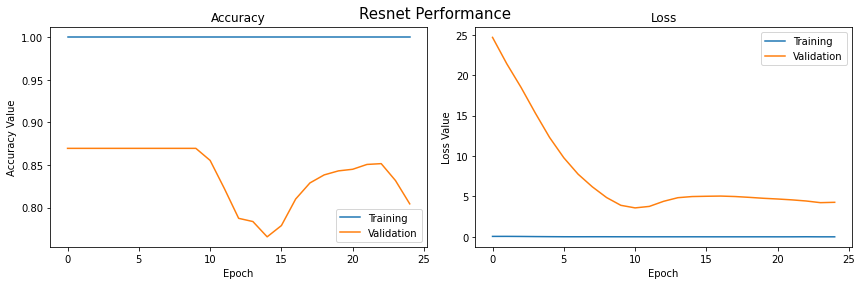

In [ ]:
import matplotlib.pyplot as plt
#make this a function 

resnet_figure, (accuracy_plot, loss_plot) = plt.subplots(1, 2, figsize=(12, 4))
t = resnet_figure.suptitle('Resnet Performance', fontsize=15)
resnet_figure.subplots_adjust(top=0.5, wspace=0.3)

# summarize history for accuracy
accuracy_plot.plot(fined_tuned_resnet_history .history['auc'])
accuracy_plot.plot(fined_tuned_resnet_history .history['val_auc'])
accuracy_plot.set_title('Accuracy')
accuracy_plot.set_ylabel('Accuracy Value')
accuracy_plot.set_xlabel('Epoch')
accuracy_plot.legend(['Training', 'Validation'], loc='lower right')

# summarize history for loss
loss_plot.plot(fined_tuned_resnet_history .history['loss'])
loss_plot.plot(fined_tuned_resnet_history .history['val_loss'])
loss_plot.set_title('Loss')
loss_plot.set_ylabel('Loss Value')
loss_plot.set_xlabel('Epoch')
loss_plot.legend(['Training', 'Validation'], loc='upper right')

resnet_figure.tight_layout()

resnet_figure.show()

# **Student Model**
## training from scratch

In [15]:
from keras.applications import MobileNetV2

mobilenet = MobileNetV2(include_top=False)

import pandas as pd
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in mobilenet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f85f6438610>,input_4,True
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f85803fbe90>,Conv1,True
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f84f22f6d50>,bn_Conv1,True
3,<keras.layers.activation.relu.ReLU object at 0x7f850f555650>,Conv1_relu,True
4,<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f84f129f2d0>,expanded_conv_depthwise,True
...,...,...,...
149,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f84f1093650>,block_16_project,True
150,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f84f1093950>,block_16_project_BN,True
151,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f84f12786d0>,Conv_1,True
152,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f84f1135750>,Conv_1_bn,True


layer setup

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer

mobilenet_model = Sequential()
mobilenet_model.add(mobilenet)
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(Dense(2))
#do something 

#do data augmentation 

for layer in mobilenet.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in mobilenet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    


In [ ]:

mobilenet_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.keras.metrics.AUC(from_logits=True)])
mobilenet_model.summary()

'''
initial_mobilenet_history = mobilenet_model.fit(x=training_image_teacher, y=training_label_teacher,
                    validation_data=(testing_image_teacher, testing_label_teacher),
                    batch_size=32,
                    epochs= 10,
                    verbose=1)

'''
initial_mobilenet_history = mobilenet_model.fit(train_generator,
                    batch_size=32,
                    epochs=10,
                    steps_per_epoch=68,
                    verbose=1)

auc = 0
for images, labels in testing_dataset:
  auc += compute_AUC(mobilenet_model, images, labels)

print(" Testing AUC: " + '{:.2f}%'.format(
  auc / len(testing_dataset) * 100))


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d_22  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_22 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
68/68 [==============================] - 23s 297ms/step - loss: 0.6307 - auc_5894: 0.7183
Epoch 2/10
68/68 [==============================] - 20s 298ms/step - l

In [16]:
set_trainable = False
# from 14 onwards set to true 
for layer in mobilenet.layers:
    if layer.name in ['block_14_expand']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    #print(layer.name)


pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in mobilenet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f85f6438610>,input_4,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f85803fbe90>,Conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f84f22f6d50>,bn_Conv1,False
3,<keras.layers.activation.relu.ReLU object at 0x7f850f555650>,Conv1_relu,False
4,<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f84f129f2d0>,expanded_conv_depthwise,False
...,...,...,...
149,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f84f1093650>,block_16_project,True
150,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f84f1093950>,block_16_project_BN,True
151,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f84f12786d0>,Conv_1,True
152,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f84f1135750>,Conv_1_bn,True


In [ ]:
from keras import backend as K
K.set_value(mobilenet_model.optimizer.learning_rate, 1e-4)

'''
fine_tune_mobilenet_history = mobilenet_model.fit(x=training_image_teacher, y=training_label_teacher,
                    validation_data=(testing_image_teacher, testing_label_teacher),
                    batch_size=32,
                    epochs=25,
                    verbose=1)
'''
initial_mobilenet_history = mobilenet_model.fit(train_generator,
                    batch_size=32,
                    epochs=25,
                    steps_per_epoch=68,
                    verbose=1)

auc = 0
for images, labels in testing_dataset:
  auc += compute_AUC(mobilenet_model, images, labels)

print(" Testing AUC: " + '{:.2f}%'.format(
  auc / len(testing_dataset) * 100))

Epoch 1/25
68/68 [==============================] - 20s 299ms/step - loss: 0.5003 - auc_5894: 0.8342
Epoch 2/25
68/68 [==============================] - 20s 299ms/step - loss: 0.4962 - auc_5894: 0.8378
Epoch 3/25
68/68 [==============================] - 20s 299ms/step - loss: 0.4819 - auc_5894: 0.8498
Epoch 4/25
68/68 [==============================] - 20s 297ms/step - loss: 0.4967 - auc_5894: 0.8376
Epoch 5/25
68/68 [==============================] - 22s 317ms/step - loss: 0.4813 - auc_5894: 0.8491
Epoch 6/25
68/68 [==============================] - 22s 317ms/step - loss: 0.4854 - auc_5894: 0.8470
Epoch 7/25
68/68 [==============================] - 20s 300ms/step - loss: 0.4879 - auc_5894: 0.8450
Epoch 8/25
68/68 [==============================] - 20s 298ms/step - loss: 0.4911 - auc_5894: 0.8414
Epoch 9/25
68/68 [==============================] - 20s 298ms/step - loss: 0.4870 - auc_5894: 0.8462
Epoch 10/25
68/68 [==============================] - 20s 299ms/step - loss: 0.4881 - auc_58

Compare teacher and student FLOPS and number of parameters

In [25]:
#!pip install keras-flops
# your code start from here for step 8
from keras_flops import get_flops
# use get_flops

#Teacher: 
teacher_flops = get_flops(fined_tuned_resnet_model, batch_size=1)
print(f"Teacher_flops: {teacher_flops / 10 ** 9:.03} G")
#Student: 
student_flops = get_flops(mobilenet_model, batch_size=1)
print(f"Student_flops: {student_flops / 10 ** 9:.03} G")

fined_tuned_resnet_model.summary()
mobilenet_model.summary()

Teacher_flops: 8.19e-06 G
Student_flops: 5.12e-06 G
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 8,933,378
Non-trainable params: 14,635,520
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Fu

Student Loss Function

Model Student+KD 

In [25]:
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature):
 
    soft_targets = tf.nn.sigmoid(teacher_logits / temperature)
    soft_student = tf.nn.sigmoid(student_logits / temperature)
    # binary cross entropy
    bce = tf.keras.losses.BinaryCrossentropy()
  
    return tf.reduce_mean(bce(soft_targets, soft_student)) * temperature ** 2

def compute_student_loss(student_model, teacher_model, images, labels, temperature, alpha):
    
    student_subclass_logits = student_model(images, training=True)

    teacher_subclass_logits = teacher_model(images, training=False)

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    student_loss_value = bce(labels, student_subclass_logits)
    student_loss_value = tf.reduce_mean(student_loss_value)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, temperature)
    
    student_loss = distillation_loss_value * alpha + student_loss_value * (1 - alpha)

    #print(distillation_loss_value)

    return student_loss



def compute_AUC(model, images, labels):

    class_logits = model(images, training=False)
    y_score = tf.nn.sigmoid(class_logits)
    #print((y_score, labels))
    
    m = tf.keras.metrics.AUC()
    m.reset_state()
    m.update_state(labels, y_score)

    return m.result().numpy()



def train_and_evaluate(student_model, teacher_model, temperature, alpha, num_epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    for epoch in range(1, num_epochs + 1):
        
        loss = 0
        batches = 0
        print('Epoch {}: '.format(epoch), end='')
        for images, labels in training_dataset:
            with tf.GradientTape() as tape:
                loss_value = compute_student_loss(student_model, teacher_model,images, labels, temperature, alpha)
                loss += loss_value

            grads = tape.gradient(loss_value, student_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, student_model.trainable_variables))

            batches += 1
            if batches >= 68:
              break
        
        print("training loss: " + '{:.2f}'.format(
            loss / 68), end='')
        
        # Run evaluation.
        num_correct = 0
        
        num_total = len(testing_dataset)
        
        for images, labels in testing_dataset:
            num_correct += compute_AUC(student_model, images, labels)

        print(" Testing AUC: " + '{:.2f}%'.format(
            num_correct / num_total * 100))
        
    return num_correct / num_total
        

Initial 10 epoch

In [ ]:
train_and_evaluate(mobilenet_model, fined_tuned_resnet_model, 4, 0.5, 10, 1e-3)

Fine Tune Student 25 epoch 

In [ ]:
set_trainable = False
# from 14 onwards set to true 
for layer in mobilenet.layers:
    if layer.name in ['block_14_expand']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    #print(layer.name)


pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in mobilenet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

train_and_evaluate(mobilenet_model, fined_tuned_resnet_model, 4, 0.5, 25, 1e-4)

Epoch 1: training loss: 5.01 Testing AUC: 76.16%
Epoch 2: training loss: 4.60 Testing AUC: 75.79%
Epoch 3: training loss: 4.47 Testing AUC: 76.31%
Epoch 4: training loss: 4.41 Testing AUC: 76.16%
Epoch 5: training loss: 4.38 Testing AUC: 77.19%
Epoch 6: training loss: 4.37 Testing AUC: 75.01%
Epoch 7: training loss: 4.36 Testing AUC: 75.78%
Epoch 8: training loss: 4.36 Testing AUC: 75.51%
Epoch 9: training loss: 4.35 Testing AUC: 76.19%
Epoch 10: training loss: 4.35 Testing AUC: 76.27%
Epoch 11: training loss: 4.34 Testing AUC: 74.89%
Epoch 12: training loss: 4.35 Testing AUC: 76.31%
Epoch 13: training loss: 4.35 Testing AUC: 76.24%
Epoch 14: training loss: 4.35 Testing AUC: 76.43%
Epoch 15: training loss: 4.34 Testing AUC: 76.03%
Epoch 16: training loss: 4.35 Testing AUC: 76.43%
Epoch 17: training loss: 4.34 Testing AUC: 77.56%
Epoch 18: training loss: 4.33 Testing AUC: 77.97%
Epoch 19: training loss: 4.33 Testing AUC: 77.92%
Epoch 20: training loss: 4.34 Testing AUC: 78.80%
Epoch 21:

# **Temperature vs Accuracy Plot** 

In [13]:
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras import optimizers

class student_model:
  def __init__(self):
    self.mobilenet = MobileNetV2(include_top=False)
    for layer in self.mobilenet.layers:
      layer.trainable = False
    self.mobilenet_model = Sequential()
    self.mobilenet_model.add(self.mobilenet)
    self.mobilenet_model.add(GlobalAveragePooling2D())
    self.mobilenet_model.add(Dense(2))
  
  def unfreeze_layers(self):
    set_trainable = False
    # from 14 onwards set to true 
    for layer in self.mobilenet.layers:
      if layer.name in ['block_14_expand']:
          set_trainable = True
      if set_trainable:
          layer.trainable = True
      else:
          layer.trainable = False
  




T=[1,2,4,16,32,64]
TEST_ACCUR=[]
for i in T:
  student = student_model()
  print('temperature:'+str(i))
  train_and_evaluate(student.mobilenet_model, fined_tuned_resnet_model, i, 0.5, 10, 1e-3)
  student.unfreeze_layers()
  auc = train_and_evaluate(student.mobilenet_model, fined_tuned_resnet_model, i, 0.5, 25, 1e-4)
  TEST_ACCUR.append(auc)



temperature:1
Epoch 1: training loss: 0.48 Testing AUC: 72.68%
Epoch 2: training loss: 0.44 Testing AUC: 74.66%
Epoch 3: training loss: 0.42 Testing AUC: 75.36%
Epoch 4: training loss: 0.41 Testing AUC: 75.27%
Epoch 5: training loss: 0.41 Testing AUC: 75.90%
Epoch 6: training loss: 0.40 Testing AUC: 76.45%
Epoch 7: training loss: 0.40 Testing AUC: 76.83%
Epoch 8: training loss: 0.40 Testing AUC: 77.37%
Epoch 9: training loss: 0.39 Testing AUC: 77.06%
Epoch 10: training loss: 0.40 Testing AUC: 78.39%
Epoch 1: training loss: 0.43 Testing AUC: 80.66%
Epoch 2: training loss: 0.30 Testing AUC: 80.18%
Epoch 3: training loss: 0.26 Testing AUC: 79.47%
Epoch 4: training loss: 0.25 Testing AUC: 80.60%
Epoch 5: training loss: 0.24 Testing AUC: 77.40%
Epoch 6: training loss: 0.24 Testing AUC: 77.67%
Epoch 7: training loss: 0.24 Testing AUC: 78.38%
Epoch 8: training loss: 0.23 Testing AUC: 80.73%
Epoch 9: training loss: 0.23 Testing AUC: 78.66%
Epoch 10: training loss: 0.23 Testing AUC: 79.92%
Epoc

 Testing AUC: 80.14%
temperature:2
Epoch 1: training loss: 1.23 Testing AUC: 73.39%
Epoch 2: training loss: 1.15 Testing AUC: 74.71%
Epoch 3: training loss: 1.13 Testing AUC: 75.45%
Epoch 4: training loss: 1.11 Testing AUC: 75.59%
Epoch 5: training loss: 1.10 Testing AUC: 76.44%
Epoch 6: training loss: 1.09 Testing AUC: 76.02%
Epoch 7: training loss: 1.08 Testing AUC: 76.46%
Epoch 8: training loss: 1.07 Testing AUC: 76.54%
Epoch 9: training loss: 1.07 Testing AUC: 76.86%
Epoch 10: training loss: 1.06 Testing AUC: 77.18%
Epoch 1: training loss: 1.12 Testing AUC: 76.49%
Epoch 2: training loss: 0.90 Testing AUC: 76.09%
Epoch 3: training loss: 0.84 Testing AUC: 75.60%
Epoch 4: training loss: 0.81 Testing AUC: 77.07%
Epoch 5: training loss: 0.80 Testing AUC: 76.64%
Epoch 6: training loss: 0.79 Testing AUC: 75.95%
Epoch 7: training loss: 0.78 Testing AUC: 76.55%
Epoch 8: training loss: 0.78 Testing AUC: 76.96%
Epoch 9: training loss: 0.77 Testing AUC: 76.77%
Epoch 10: training loss: 0.77 Tes

 Testing AUC: 77.02%
temperature:4
Epoch 1: training loss: 4.78 Testing AUC: 71.44%
Epoch 2: training loss: 4.62 Testing AUC: 73.29%
Epoch 3: training loss: 4.55 Testing AUC: 73.35%
Epoch 4: training loss: 4.52 Testing AUC: 73.93%
Epoch 5: training loss: 4.49 Testing AUC: 74.85%
Epoch 6: training loss: 4.47 Testing AUC: 74.86%
Epoch 7: training loss: 4.45 Testing AUC: 75.74%
Epoch 8: training loss: 4.45 Testing AUC: 75.25%
Epoch 9: training loss: 4.43 Testing AUC: 76.51%
Epoch 10: training loss: 4.42 Testing AUC: 76.63%
Epoch 1: training loss: 4.48 Testing AUC: 78.38%
Epoch 2: training loss: 4.11 Testing AUC: 77.14%
Epoch 3: training loss: 3.99 Testing AUC: 76.10%
Epoch 4: training loss: 3.90 Testing AUC: 77.35%
Epoch 5: training loss: 3.90 Testing AUC: 76.06%
Epoch 6: training loss: 3.88 Testing AUC: 77.65%
Epoch 7: training loss: 3.88 Testing AUC: 75.83%
Epoch 8: training loss: 3.86 Testing AUC: 76.99%
Epoch 9: training loss: 3.86 Testing AUC: 76.64%
Epoch 10: training loss: 3.85 Tes

 Testing AUC: 77.23%
temperature:16
Epoch 1: training loss: 86.99 Testing AUC: 68.63%
Epoch 2: training loss: 86.32 Testing AUC: 70.02%
Epoch 3: training loss: 86.11 Testing AUC: 72.29%
Epoch 4: training loss: 85.98 Testing AUC: 72.18%
Epoch 5: training loss: 85.90 Testing AUC: 71.05%
Epoch 6: training loss: 85.85 Testing AUC: 73.30%
Epoch 7: training loss: 85.80 Testing AUC: 72.77%
Epoch 8: training loss: 85.77 Testing AUC: 74.85%
Epoch 9: training loss: 85.75 Testing AUC: 74.19%
Epoch 10: training loss: 85.71 Testing AUC: 72.61%
Epoch 1: training loss: 85.80 Testing AUC: 73.51%
Epoch 2: training loss: 85.08 Testing AUC: 75.74%
Epoch 3: training loss: 84.82 Testing AUC: 76.21%
Epoch 4: training loss: 84.67 Testing AUC: 77.39%
Epoch 5: training loss: 84.62 Testing AUC: 77.39%
Epoch 6: training loss: 84.57 Testing AUC: 75.32%
Epoch 7: training loss: 84.57 Testing AUC: 75.00%
Epoch 8: training loss: 84.54 Testing AUC: 76.01%
Epoch 9: training loss: 84.55 Testing AUC: 75.93%
Epoch 10: tra

 Testing AUC: 76.72%
temperature:32
Epoch 1: training loss: 352.74 Testing AUC: 69.87%
Epoch 2: training loss: 352.15 Testing AUC: 72.10%
Epoch 3: training loss: 351.95 Testing AUC: 71.05%
Epoch 4: training loss: 351.82 Testing AUC: 71.19%
Epoch 5: training loss: 351.73 Testing AUC: 72.76%
Epoch 6: training loss: 351.67 Testing AUC: 73.16%
Epoch 7: training loss: 351.61 Testing AUC: 73.75%
Epoch 8: training loss: 351.57 Testing AUC: 72.74%
Epoch 9: training loss: 351.54 Testing AUC: 73.48%
Epoch 10: training loss: 351.51 Testing AUC: 73.97%
Epoch 1: training loss: 351.59 Testing AUC: 76.81%
Epoch 2: training loss: 350.87 Testing AUC: 77.84%
Epoch 3: training loss: 350.59 Testing AUC: 75.31%
Epoch 4: training loss: 350.41 Testing AUC: 80.15%
Epoch 5: training loss: 350.34 Testing AUC: 79.69%
Epoch 6: training loss: 350.32 Testing AUC: 80.91%
Epoch 7: training loss: 350.30 Testing AUC: 80.23%
Epoch 8: training loss: 350.30 Testing AUC: 77.93%
Epoch 9: training loss: 350.29 Testing AUC: 7

 Testing AUC: 77.24%
temperature:64
Epoch 1: training loss: 1417.54 Testing AUC: 67.29%
Epoch 2: training loss: 1416.85 Testing AUC: 69.54%
Epoch 3: training loss: 1416.59 Testing AUC: 71.01%
Epoch 4: training loss: 1416.45 Testing AUC: 72.00%
Epoch 5: training loss: 1416.35 Testing AUC: 71.45%
Epoch 6: training loss: 1416.28 Testing AUC: 73.09%
Epoch 7: training loss: 1416.22 Testing AUC: 73.17%
Epoch 8: training loss: 1416.17 Testing AUC: 73.12%
Epoch 9: training loss: 1416.13 Testing AUC: 72.42%
Epoch 10: training loss: 1416.11 Testing AUC: 74.75%
Epoch 1: training loss: 1416.19 Testing AUC: 78.10%
Epoch 2: training loss: 1415.43 Testing AUC: 76.66%
Epoch 3: training loss: 1415.13 Testing AUC: 79.60%
Epoch 4: training loss: 1414.98 Testing AUC: 80.20%
Epoch 5: training loss: 1414.88 Testing AUC: 80.29%
Epoch 6: training loss: 1414.85 Testing AUC: 79.10%
Epoch 7: training loss: 1414.87 Testing AUC: 76.95%
Epoch 8: training loss: 1414.84 Testing AUC: 79.39%
Epoch 9: training loss: 141

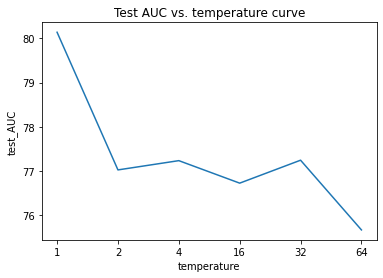

In [18]:
import matplotlib.pyplot as plt

x=['1','2','4','16','32','64']
l=plt.plot(x,TEST_ACCUR)

plt.title('Test AUC vs. temperature curve')
plt.xlabel('temperature')
plt.ylabel('test_AUC')
plt.show()

Alpha vs Accuracy Plot

In [28]:
#Test alpha with T = 16

ALPHA=[0.3, 0.5, 0.7]
TEST_ACCUR_ALPHA=[]
for i in ALPHA:
  student = student_model()
  print('temperature:'+str(i))
  train_and_evaluate(student.mobilenet_model, fined_tuned_resnet_model, 4, i, 10, 1e-3)
  student.unfreeze_layers()
  auc = train_and_evaluate(student.mobilenet_model, fined_tuned_resnet_model, 4, i, 25, 1e-4)
  TEST_ACCUR_ALPHA.append(auc)

temperature:0.3
Epoch 1: training loss: 3.39 Testing AUC: 71.73%
Epoch 2: training loss: 3.25 Testing AUC: 73.74%
Epoch 3: training loss: 3.20 Testing AUC: 75.22%
Epoch 4: training loss: 3.19 Testing AUC: 74.40%
Epoch 5: training loss: 3.15 Testing AUC: 75.26%
Epoch 6: training loss: 3.13 Testing AUC: 75.85%
Epoch 7: training loss: 3.11 Testing AUC: 75.51%
Epoch 8: training loss: 3.11 Testing AUC: 75.74%
Epoch 9: training loss: 3.09 Testing AUC: 75.86%
Epoch 10: training loss: 3.11 Testing AUC: 77.19%
Epoch 1: training loss: 3.09 Testing AUC: 75.74%
Epoch 2: training loss: 3.08 Testing AUC: 76.20%
Epoch 3: training loss: 3.09 Testing AUC: 75.40%
Epoch 4: training loss: 3.07 Testing AUC: 76.21%
Epoch 5: training loss: 3.07 Testing AUC: 76.15%
Epoch 6: training loss: 3.08 Testing AUC: 75.90%
Epoch 7: training loss: 3.06 Testing AUC: 75.81%
Epoch 8: training loss: 3.08 Testing AUC: 75.91%
Epoch 9: training loss: 3.08 Testing AUC: 76.00%
Epoch 10: training loss: 3.07 Testing AUC: 76.14%
Ep

 Testing AUC: 76.09%
temperature:0.5
Epoch 1: training loss: 5.05 Testing AUC: 72.70%
Epoch 2: training loss: 4.86 Testing AUC: 73.94%
Epoch 3: training loss: 4.83 Testing AUC: 74.79%
Epoch 4: training loss: 4.79 Testing AUC: 74.85%
Epoch 5: training loss: 4.77 Testing AUC: 74.35%
Epoch 6: training loss: 4.74 Testing AUC: 74.59%
Epoch 7: training loss: 4.72 Testing AUC: 75.15%
Epoch 8: training loss: 4.69 Testing AUC: 75.46%
Epoch 9: training loss: 4.68 Testing AUC: 75.18%
Epoch 10: training loss: 4.69 Testing AUC: 74.86%
Epoch 1: training loss: 4.67 Testing AUC: 74.73%
Epoch 2: training loss: 4.65 Testing AUC: 75.00%
Epoch 3: training loss: 4.64 Testing AUC: 75.20%
Epoch 4: training loss: 4.66 Testing AUC: 75.04%
Epoch 5: training loss: 4.67 Testing AUC: 74.94%
Epoch 6: training loss: 4.67 Testing AUC: 75.19%
Epoch 7: training loss: 4.65 Testing AUC: 74.86%
Epoch 8: training loss: 4.66 Testing AUC: 74.81%
Epoch 9: training loss: 4.66 Testing AUC: 74.83%
Epoch 10: training loss: 4.67 T

 Testing AUC: 74.97%
temperature:0.7
Epoch 1: training loss: 6.73 Testing AUC: 70.72%
Epoch 2: training loss: 6.48 Testing AUC: 72.58%
Epoch 3: training loss: 6.40 Testing AUC: 73.51%
Epoch 4: training loss: 6.37 Testing AUC: 73.68%
Epoch 5: training loss: 6.33 Testing AUC: 73.87%
Epoch 6: training loss: 6.28 Testing AUC: 73.34%
Epoch 7: training loss: 6.25 Testing AUC: 73.75%
Epoch 8: training loss: 6.27 Testing AUC: 73.87%
Epoch 9: training loss: 6.25 Testing AUC: 73.58%
Epoch 10: training loss: 6.22 Testing AUC: 73.79%
Epoch 1: training loss: 6.25 Testing AUC: 74.32%
Epoch 2: training loss: 6.20 Testing AUC: 74.20%
Epoch 3: training loss: 6.25 Testing AUC: 74.21%
Epoch 4: training loss: 6.21 Testing AUC: 73.22%
Epoch 5: training loss: 6.23 Testing AUC: 74.14%
Epoch 6: training loss: 6.20 Testing AUC: 74.05%
Epoch 7: training loss: 6.21 Testing AUC: 74.22%
Epoch 8: training loss: 6.21 Testing AUC: 74.66%
Epoch 9: training loss: 6.22 Testing AUC: 73.79%
Epoch 10: training loss: 6.21 T

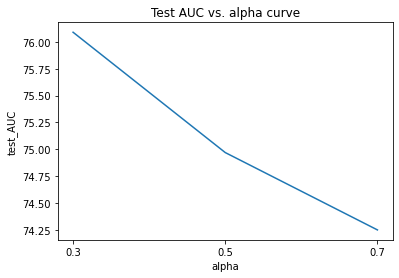

In [3]:
import matplotlib.pyplot as plt
x=['0.3','0.5','0.7']
TEST_ACCUR_ALPHA = [76.09, 74.97, 74.25]
alpha_plot=plt.plot(x,TEST_ACCUR_ALPHA)
plt.title('Test AUC vs. alpha curve')
plt.xlabel('alpha')
plt.ylabel('test_AUC')
plt.show()

Flops 

In [ ]:
!pip install keras-flops
# your code start from here for step 8
from keras_flops import get_flops
# use get_flops

#Teacher: 
teacher_flops = get_flops(fined_tuned_resnet_model, batch_size=1)
print(f"Teacher_flops: {teacher_flops / 10 ** 9:.03} G")
#Student: 
student_flops = get_flops(mobilenet_model, batch_size=1)
print(f"Student_flops: {student_flops / 10 ** 9:.03} G")

student_no_dist_flops = get_flops(fc_model_no_distillation, batch_size=1)
print(f"Student_no_dist_flops: {student_no_dist_flops / 10 ** 9:.03} G")

# **Subclass distillation** 
teacher

In [ ]:
resnet_sub = resnet_v2.ResNet50V2(include_top=False)
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
import math

#print(resnet_train_features.shape[1:])

#input_shape = resnet_train_features.shape

resnet_sub = resnet_v2.ResNet50V2(include_top=False)

resnet_model_sub = Sequential()
resnet_model_sub.add(resnet_sub)
resnet_model_sub.add(GlobalAveragePooling2D())
# assign 1 class for hp, 3 classes for ssa 
resnet_model_sub.add(Dense(4))


def concat_sub_class(subclass_logits):
  # HP first subclass, SSA next 3 subclass, need sum 
  logits_ssa = tf.reduce_sum(subclass_logits[:,1:], axis=1)
  logits_hp = subclass_logits[:,0]
  class_logits = tf.stack([logits_hp, logits_ssa], axis=1)

  return class_logits



def loss_function(model, images, labels, temperature, beta):

  subclass_logits = model(images, training=True)
  subclass_logits = tf.nn.softmax(subclass_logits)
  # tf.shape(subclass_logits)[0] is batch size 
  # sum all subclass of a class, get back size 256 x 10 logits 
  # print(subclass_logits)
  #class_logits = tf.reduce_sum(tf.reshape(subclass_logits, (tf.shape(subclass_logits)[0], 2, 10)),axis=2)
  # print(class_logits)

  class_logits = concat_sub_class(subclass_logits)

  bce = tf.keras.losses.BinaryCrossentropy()


  cross_entropy_loss_value = tf.reduce_mean(bce(labels, class_logits))

  #print(cross_entropy_loss_value)

  total_loss = cross_entropy_loss_value  +  beta * Auxiliary_loss(subclass_logits, temperature)

  #print(total_loss)

  return total_loss 


def Auxiliary_loss(subclass_logits_Z, temperature):
  mean = tf.math.reduce_mean(subclass_logits_Z, axis = 1)
  var = tf.math.reduce_variance(subclass_logits_Z, axis = 1)
  normalizer = tf.keras.layers.Normalization(axis=0, mean=mean, variance=var)
  subclass_logits_Z = normalizer(subclass_logits_Z)

  subclass_logits_Z_transposed = tf.transpose(subclass_logits_Z)
  logics_vectors = tf.matmul(subclass_logits_Z, subclass_logits_Z_transposed)
  logics_vectors /= temperature
  exp_values = tf.math.exp(logics_vectors)
  log_term = tf.reduce_sum(exp_values, 1)
  log_results = tf.math.log(log_term)
  log_results -= (1/temperature)
  log_results -= math.log(tf.shape(subclass_logits_Z)[0])
  auxiliary_loss = tf.reduce_mean(log_results)
  return auxiliary_loss


    

def compute_AUC_sub(model, images, labels):

  subclass_logits = model(images, training=False)
  # tf.shape(subclass_logits)[0] is batch size 
  #print(subclass_logits)
  #class_logits = tf.reduce_sum(tf.reshape(subclass_logits, (tf.shape(subclass_logits)[0], 2, 10)),axis=2)
  #print(class_logits)

  class_logits = concat_sub_class(subclass_logits)

  y_score = tf.nn.sigmoid(class_logits)
  
  m = tf.keras.metrics.AUC()
  m.reset_state()
  m.update_state(labels, y_score)

  return m.result().numpy()

    
def train_and_evaluate_teacher(model, temperature, beta, num_epochs, learning_rate):
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  for epoch in range(1, num_epochs + 1):
    
    loss = 0
    batches = 0
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in train_generator:
      with tf.GradientTape() as tape:
        loss_value = loss_function(model,images, labels, temperature, beta)
        loss += loss_value

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      batches += 1
      if batches >= 68:
        break
    
    print("training loss: " + '{:.2f}'.format(
        loss / 68), end='')
    
    # Run evaluation.
    num_correct = 0
    
    num_total = len(testing_dataset)
    
    for images, labels in testing_dataset:
      num_correct += compute_AUC_sub(model, images, labels)

    print(" Testing AUC: " + '{:.2f}%'.format(
      num_correct / num_total * 100))
        


import pandas as pd

for layer in resnet_sub.layers:
  layer.trainable = False
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in resnet_sub.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 





,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f04dcc4cfd0>,input_7,False
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f05582e6a50>,conv1_pad,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f05582e6650>,conv1_conv,False
3,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f04dd661d50>,pool1_pad,False
4,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f04dd04aad0>,pool1_pool,False
...,...,...,...
185,<keras.layers.core.activation.Activation object at 0x7f04f4318110>,conv5_block3_2_relu,False
186,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f04f4364a90>,conv5_block3_3_conv,False
187,<keras.layers.merging.add.Add object at 0x7f04f4364b50>,conv5_block3_out,False
188,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f04f44a1550>,post_bn,False


In [ ]:
train_and_evaluate_teacher(resnet_model_sub,20, 0.1, 10, 1e-3)

Epoch 1: training loss: 4.47 Testing AUC: 63.44%
Epoch 2: training loss: 4.47 Testing AUC: 63.26%
Epoch 3: training loss: 4.47 Testing AUC: 63.09%
Epoch 4: training loss: 4.47 Testing AUC: 63.09%
Epoch 5: training loss: 4.47 Testing AUC: 63.26%
Epoch 6: training loss: 4.47 Testing AUC: 63.44%
Epoch 7: training loss: 4.47 Testing AUC: 63.00%
Epoch 8: training loss: 4.47 Testing AUC: 63.00%
Epoch 9: training loss: 4.47 Testing AUC: 63.26%
Epoch 10: training loss: 4.47 Testing AUC: 63.18%


In [ ]:
!mkdir -p checkpoints
resnet_model_sub.save_weights('./checkpoints/teacher_subclass_DA_Initial_checkpoint')

In [ ]:
set_trainable = False
for layer in resnet_sub.layers:
    if layer.name in ['conv4_block1_preact_bn','conv5_block3_3_conv', 'conv5_block3_2_conv']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in resnet_sub.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f95eec52590>,input_4,False
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f95eeeee910>,conv1_pad,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f95ee96b390>,conv1_conv,False
3,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f95ee980c90>,pool1_pad,False
4,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f95ee999ad0>,pool1_pool,False
...,...,...,...
185,<keras.layers.core.activation.Activation object at 0x7f95ee6be490>,conv5_block3_2_relu,True
186,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f95ee6af150>,conv5_block3_3_conv,True
187,<keras.layers.merging.add.Add object at 0x7f95ee6af5d0>,conv5_block3_out,True
188,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f95ee98d210>,post_bn,True


In [ ]:
train_and_evaluate_teacher(resnet_model_sub,20, 0.1, 25, 1e-4)

#resnet_model_sub.save_weights('./checkpoints/teacher_subclass_checkpoint')

Epoch 1: training loss: 0.52 Testing AUC: 65.37%
Epoch 2: training loss: 0.41 Testing AUC: 71.09%
Epoch 3: training loss: 0.37 Testing AUC: 77.67%
Epoch 4: training loss: 0.35 Testing AUC: 78.58%
Epoch 5: training loss: 0.31 Testing AUC: 84.79%
Epoch 6: training loss: 0.30 Testing AUC: 85.24%
Epoch 7: training loss: 0.28 Testing AUC: 80.28%
Epoch 8: training loss: 0.25 Testing AUC: 85.78%
Epoch 9: training loss: 0.25 Testing AUC: 81.44%
Epoch 10: training loss: 0.23 Testing AUC: 80.32%
Epoch 11: training loss: 0.22 Testing AUC: 84.82%
Epoch 12: training loss: 0.23 Testing AUC: 83.29%
Epoch 13: training loss: 0.18 Testing AUC: 84.55%
Epoch 14: training loss: 0.19 Testing AUC: 81.89%
Epoch 15: training loss: 0.17 Testing AUC: 82.23%
Epoch 16: training loss: 0.17 Testing AUC: 81.07%
Epoch 17: training loss: 0.15 Testing AUC: 85.27%
Epoch 18: training loss: 0.17 Testing AUC: 83.93%
Epoch 19: training loss: 0.14 Testing AUC: 82.09%
Epoch 20: training loss: 0.13 Testing AUC: 86.06%
Epoch 21:

In [ ]:
auc = 0
for images, labels in testing_dataset:
  auc += compute_AUC_sub(resnet_model_sub, images, labels)

print(" Testing AUC: " + '{:.2f}%'.format(
  auc / len(testing_dataset) * 100))

 Testing AUC: 83.35%


In [ ]:
!mkdir -p checkpoints
resnet_model_sub.save_weights('./checkpoints/teacher_subclass_DA_FineTuned_checkpoint')

In [ ]:
resnet_model_sub.load_weights('./checkpoints//teacher_subclass_DA_FineTuned_checkpoint')

## Student subclass

In [ ]:
from keras.applications import MobileNetV2
from keras.models import Sequential

mobilenet_sub = MobileNetV2(include_top=False)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D

mobilenet_model_sub = Sequential()
mobilenet_model_sub.add(mobilenet_sub)
mobilenet_model_sub.add(GlobalAveragePooling2D())
mobilenet_model_sub.add(Dense(4))
#do something 


#do data augmentation 

for layer in mobilenet_sub.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in mobilenet_sub.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

def concat_sub_class(subclass_logits):
  # HP first subclass, SSA next 3 subclass, need sum 
  logits_ssa = tf.reduce_sum(subclass_logits[:,1:], axis=1)
  logits_hp = subclass_logits[:,0]
  class_logits = tf.stack([logits_hp, logits_ssa], axis=1)

  return class_logits

def distillation_loss_sub(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature):
 
    soft_targets = tf.nn.softmax(teacher_logits / temperature, axis = 1)
    soft_student = tf.nn.softmax(student_logits / temperature, axis = 1)
    # binary cross entropy
    cce = tf.keras.losses.CategoricalCrossentropy()
  
    return tf.reduce_mean(cce(soft_targets, soft_student)) * temperature ** 2

def compute_student_loss_sub(student_model, teacher_model, images, labels, temperature, alpha):
    
    student_subclass_logits = student_model(images, training=True)

    teacher_subclass_logits = teacher_model(images, training=False)

    student_logits = tf.nn.softmax(student_subclass_logits , axis = 1)

    student_logits = concat_sub_class(student_logits)

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    student_loss_value = bce(labels, student_logits)
    student_loss_value = tf.reduce_mean(student_loss_value)
    distillation_loss_value = distillation_loss_sub(teacher_subclass_logits, student_subclass_logits, temperature)
    
    student_loss = distillation_loss_value * alpha + student_loss_value * (1 - alpha)


    return student_loss


def train_and_evaluate_student_sub(student_model, teacher_model, temperature, alpha, num_epochs, learning_rate):


  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  for epoch in range(1, num_epochs + 1):

    loss = 0
    batches = 0
    print('Epoch {}: '.format(epoch), end='')

    for images, labels in training_dataset:
      with tf.GradientTape() as tape:
        loss_value = compute_student_loss_sub(student_model, teacher_model,images, labels, temperature, alpha)
        loss += loss_value

      grads = tape.gradient(loss_value, student_model.trainable_variables)
      optimizer.apply_gradients(zip(grads, student_model.trainable_variables))

      batches += 1
      if batches >= 68:
        break

    print("training loss: " + '{:.2f}'.format(
        loss / 68), end='')

    # Run evaluation.
    num_correct = 0

    num_total = len(testing_dataset)

    for images, labels in testing_dataset:
      num_correct += compute_AUC_sub(student_model, images, labels)

    print(" Testing AUC: " + '{:.2f}%'.format(
      num_correct / num_total * 100))


In [ ]:
train_and_evaluate_student_sub(mobilenet_model_sub, resnet_model_sub, 16, 0.5, 10, 1e-3)

Epoch 1: training loss: 175.90 Testing AUC: 69.54%
Epoch 2: training loss: 175.11 Testing AUC: 70.76%
Epoch 3: training loss: 174.91 Testing AUC: 73.00%
Epoch 4: training loss: 174.75 Testing AUC: 71.84%
Epoch 5: training loss: 174.68 Testing AUC: 74.22%
Epoch 6: training loss: 174.60 Testing AUC: 74.67%
Epoch 7: training loss: 174.56 Testing AUC: 74.56%
Epoch 8: training loss: 174.51 Testing AUC: 75.46%
Epoch 9: training loss: 174.50 Testing AUC: 74.44%
Epoch 10: training loss: 174.47 Testing AUC: 74.68%


In [ ]:
mobilenet_model_sub.save_weights('./checkpoints/student_subclass_DA_initial_checkpoint')

In [ ]:
mobilenet_model_sub.load_weights('./checkpoints/student_subclass_DA_initial_checkpoint')

In [ ]:
set_trainable = False
# from 14 onwards set to true 
for layer in mobilenet_sub.layers:
    if layer.name in ['block_14_expand']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in mobilenet_sub.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f04dd4e9e90>,input_10,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f04dd73ccd0>,Conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f04dd721150>,bn_Conv1,False
3,<keras.layers.activation.relu.ReLU object at 0x7f04dcb18a90>,Conv1_relu,False
4,<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f04f42c8450>,expanded_conv_depthwise,False
...,...,...,...
149,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f04dd7e6f50>,block_16_project,True
150,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f04dd4a8ed0>,block_16_project_BN,True
151,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f04dcee3a10>,Conv_1,True
152,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f04dd487e10>,Conv_1_bn,True


In [ ]:

train_and_evaluate_student_sub(mobilenet_model_sub, resnet_model_sub, 16, 0.5, 25, 1e-4)

Epoch 1: training loss: 174.85 Testing AUC: 70.60%
Epoch 2: training loss: 173.76 Testing AUC: 71.38%
Epoch 3: training loss: 173.30 Testing AUC: 75.19%
Epoch 4: training loss: 173.14 Testing AUC: 72.38%
Epoch 5: training loss: 173.06 Testing AUC: 72.28%
Epoch 6: training loss: 173.02 Testing AUC: 73.40%
Epoch 7: training loss: 173.00 Testing AUC: 74.64%
Epoch 8: training loss: 173.02 Testing AUC: 74.74%
Epoch 9: training loss: 172.98 Testing AUC: 72.36%
Epoch 10: training loss: 173.01 Testing AUC: 72.11%
Epoch 11: training loss: 173.00 Testing AUC: 73.47%
Epoch 12: training loss: 172.98 Testing AUC: 74.38%
Epoch 13: training loss: 172.97 Testing AUC: 73.72%
Epoch 14: training loss: 172.95 Testing AUC: 74.40%
Epoch 15: training loss: 172.97 Testing AUC: 74.10%
Epoch 16: training loss: 172.95 Testing AUC: 74.95%
Epoch 17: training loss: 172.96 Testing AUC: 73.76%
Epoch 18: training loss: 172.95 Testing AUC: 75.46%
Epoch 19: training loss: 172.95 Testing AUC: 75.30%
Epoch 20: training lo

# **Train teacher and student without pretrained weights/transfer learning**

## Teacher

In [22]:
resnet_scratch = resnet_v2.ResNet50V2(include_top=False, weights=None)

resnet_scratch_model = Sequential()
resnet_scratch_model.add(resnet_scratch)
resnet_scratch_model.add(GlobalAveragePooling2D())
resnet_scratch_model.add(Dense(2))

resnet_scratch_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.keras.metrics.AUC(from_logits=True)])

def compute_AUC(model, images, labels):

    class_logits = model(images, training=False)

    y_score = tf.nn.sigmoid(class_logits)
    #print((y_score, labels))
    
    m = tf.keras.metrics.AUC()
    m.reset_state()
    m.update_state(labels, y_score)

    return m.result().numpy()

In [23]:
resnet_scratch_history = resnet_scratch_model.fit(train_generator,
                    batch_size=32,
                    epochs=10,
                    steps_per_epoch=68,
                    verbose=1)



auc = 0
for images, labels in testing_dataset:
  auc += compute_AUC(resnet_scratch_model, images, labels)

print(" Testing AUC: " + '{:.2f}%'.format(
  auc / len(testing_dataset) * 100))

Epoch 1/10
68/68 [==============================] - 36s 449ms/step - loss: 0.6031 - auc_2: 0.7618
Epoch 2/10
68/68 [==============================] - 34s 503ms/step - loss: 0.5309 - auc_2: 0.8059
Epoch 3/10
68/68 [==============================] - 29s 431ms/step - loss: 0.5253 - auc_2: 0.8143
Epoch 4/10
68/68 [==============================] - 30s 436ms/step - loss: 0.4986 - auc_2: 0.8305
Epoch 5/10
68/68 [==============================] - 30s 430ms/step - loss: 0.4781 - auc_2: 0.8448
Epoch 6/10
68/68 [==============================] - 30s 432ms/step - loss: 0.4839 - auc_2: 0.8432
Epoch 7/10
68/68 [==============================] - 29s 427ms/step - loss: 0.4637 - auc_2: 0.8560
Epoch 8/10
68/68 [==============================] - 29s 430ms/step - loss: 0.4580 - auc_2: 0.8605
Epoch 9/10
68/68 [==============================] - 30s 432ms/step - loss: 0.4671 - auc_2: 0.8554
Epoch 10/10
68/68 [==============================] - 29s 430ms/step - loss: 0.4567 - auc_2: 0.8584
 Testing AUC: 36.32

In [24]:
from keras import backend as K
K.set_value(resnet_scratch_model.optimizer.learning_rate, 1e-4)

resnet_scratch_history = resnet_scratch_model.fit(train_generator,
                    batch_size=32,
                    epochs=25,
                    steps_per_epoch=68,
                    verbose=1)

auc = 0
for images, labels in testing_dataset:
  auc += compute_AUC(resnet_scratch_model, images, labels)

print(" Testing AUC: " + '{:.2f}%'.format(
  auc / len(testing_dataset) * 100))

Epoch 1/25
68/68 [==============================] - 28s 408ms/step - loss: 0.4387 - auc_2: 0.8731
Epoch 2/25
68/68 [==============================] - 28s 403ms/step - loss: 0.4202 - auc_2: 0.8835
Epoch 3/25
68/68 [==============================] - 28s 405ms/step - loss: 0.4104 - auc_2: 0.8907
Epoch 4/25
68/68 [==============================] - 28s 406ms/step - loss: 0.3991 - auc_2: 0.8977
Epoch 5/25
68/68 [==============================] - 28s 407ms/step - loss: 0.4068 - auc_2: 0.8926
Epoch 6/25
68/68 [==============================] - 27s 401ms/step - loss: 0.3892 - auc_2: 0.9034
Epoch 7/25
68/68 [==============================] - 28s 405ms/step - loss: 0.3888 - auc_2: 0.9031
Epoch 8/25
68/68 [==============================] - 28s 403ms/step - loss: 0.3840 - auc_2: 0.9086
Epoch 9/25
68/68 [==============================] - 28s 406ms/step - loss: 0.3868 - auc_2: 0.9052
Epoch 10/25
68/68 [==============================] - 31s 451ms/step - loss: 0.3698 - auc_2: 0.9142
Epoch 11/25
68/68 [

## Student

In [28]:
from keras.applications import MobileNetV2

mobilenet_scratch = MobileNetV2(include_top=False)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer

mobilenet_scratch_model = Sequential()
mobilenet_scratch_model.add(mobilenet_scratch)
mobilenet_scratch_model.add(GlobalAveragePooling2D())
mobilenet_scratch_model.add(Dense(2))

train_and_evaluate(mobilenet_scratch_model, resnet_scratch_model, 4, 0.5, 10, 1e-3)
train_and_evaluate(mobilenet_scratch_model, resnet_scratch_model, 4, 0.5, 25, 1e-4)

Epoch 1: training loss: 5.24 Testing AUC: 63.26%
Epoch 2: training loss: 5.08 Testing AUC: 63.18%
Epoch 3: training loss: 5.02 Testing AUC: 63.26%
Epoch 4: training loss: 5.00 Testing AUC: 63.44%
Epoch 5: training loss: 5.00 Testing AUC: 66.64%
Epoch 6: training loss: 4.98 Testing AUC: 66.03%
Epoch 7: training loss: 4.98 Testing AUC: 63.27%
Epoch 8: training loss: 4.97 Testing AUC: 64.57%
Epoch 9: training loss: 4.97 Testing AUC: 69.31%
Epoch 10: training loss: 4.97 Testing AUC: 66.28%
Epoch 1: training loss: 4.96 Testing AUC: 68.14%
Epoch 2: training loss: 4.94 Testing AUC: 69.51%
Epoch 3: training loss: 4.94 Testing AUC: 71.66%
Epoch 4: training loss: 4.94 Testing AUC: 72.76%
Epoch 5: training loss: 4.94 Testing AUC: 74.53%
Epoch 6: training loss: 4.93 Testing AUC: 74.95%
Epoch 7: training loss: 4.93 Testing AUC: 76.32%
Epoch 8: training loss: 4.93 Testing AUC: 77.04%
Epoch 9: training loss: 4.93 Testing AUC: 78.52%
Epoch 10: training loss: 4.93 Testing AUC: 81.15%
Epoch 11: training

0.8773291860857317